In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import arviz as az

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

#### Code 4.1

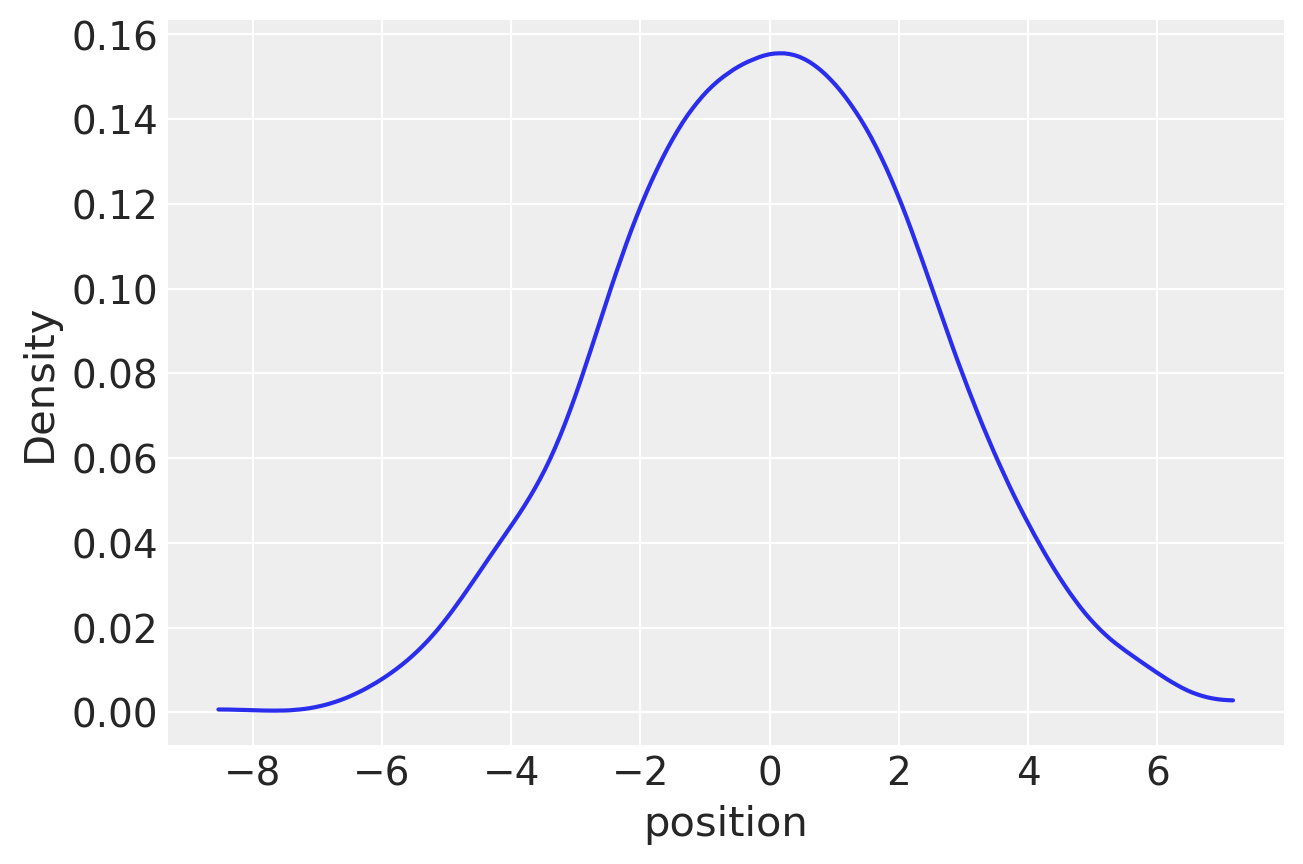

In [3]:
pos = np.random.uniform(-1, 1, size=(16, 1000)).sum(0)
az.plot_kde(pos)
plt.xlabel('position')
plt.ylabel('Density');

#### Code 4.2 and 4.3

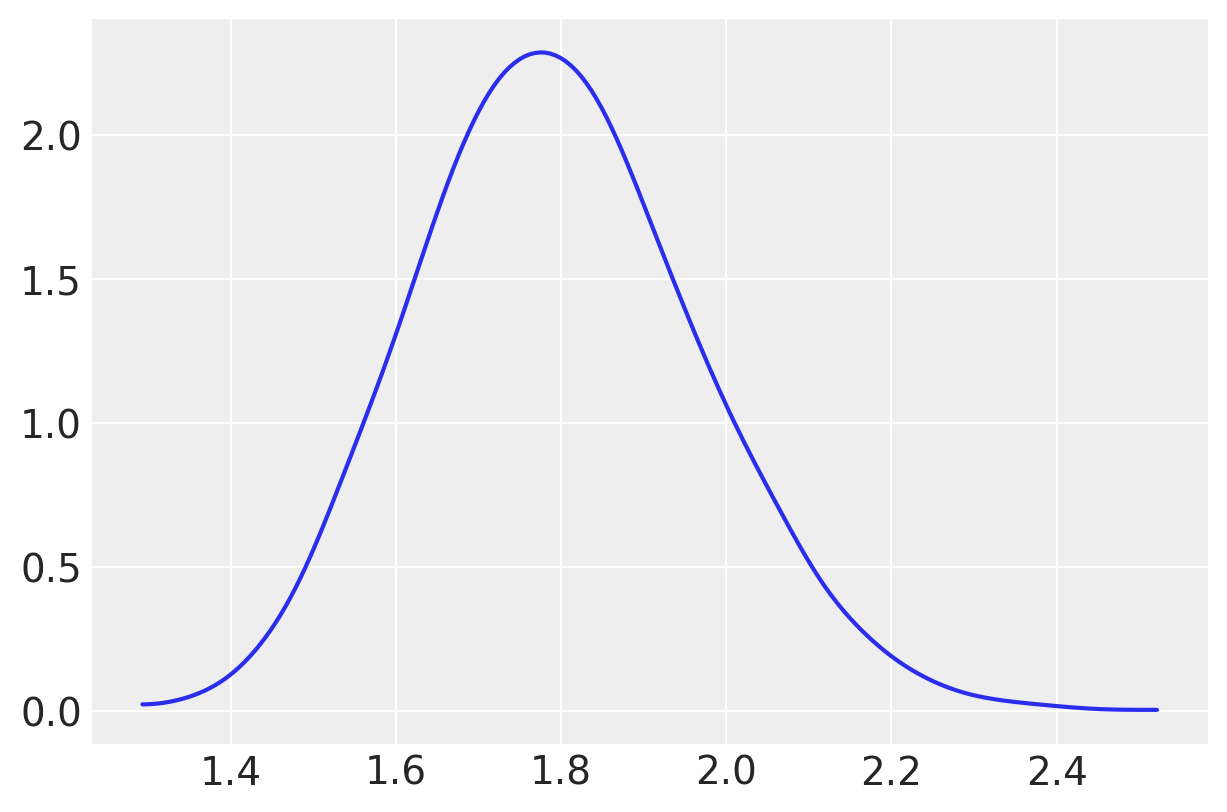

In [4]:
pos = np.random.uniform(1, 1.1, size=(12, 10000)).prod(0)
az.plot_kde(pos);

#### Code 4.4

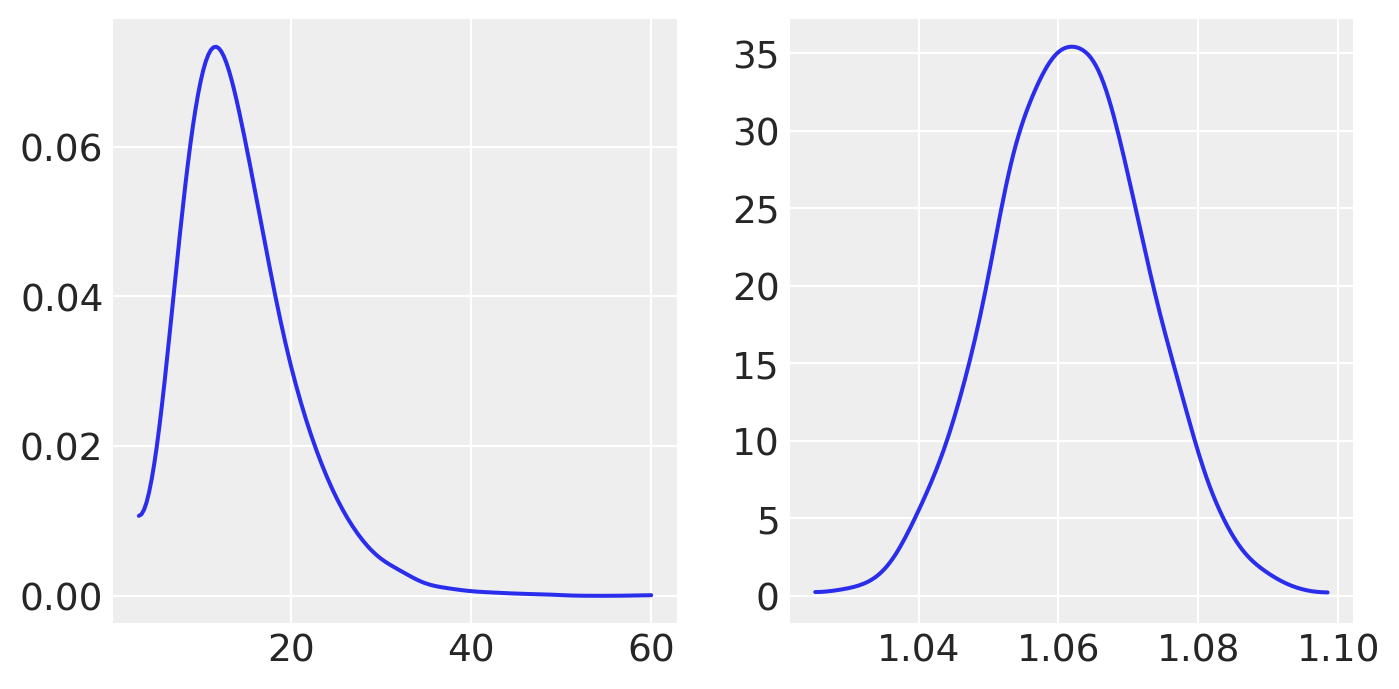

In [5]:
big = np.random.uniform(1, 1.5, size=(12, 10000)).prod(0)
small = np.random.uniform(1, 1.01, size=(12, 10000)).prod(0)
_, ax = plt.subplots(1,2, figsize=(8,4))
az.plot_kde(big, ax=ax[0])
az.plot_kde(small, ax=ax[1]);

#### Code 4.5

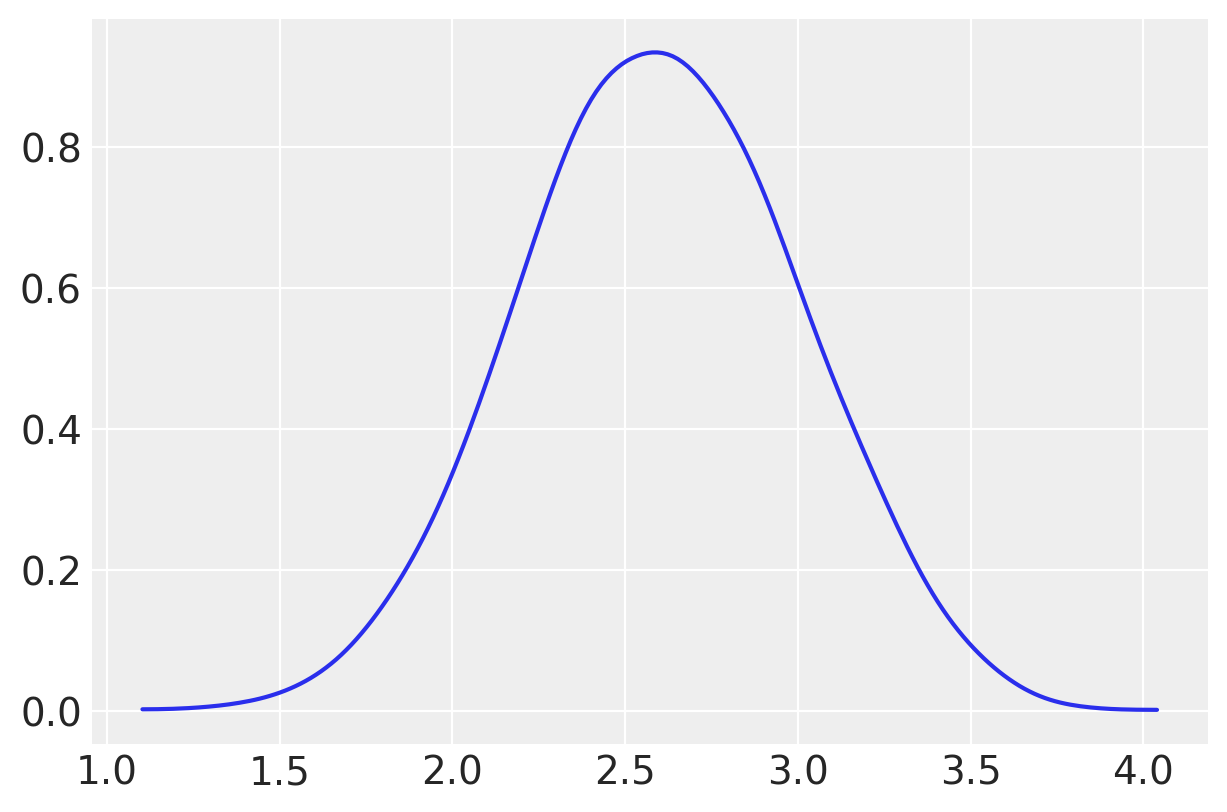

In [6]:
log_big = np.log(np.random.uniform(1, 1.5, size=(12, 10000)).prod(0))
az.plot_kde(log_big);

#### Code 4.6

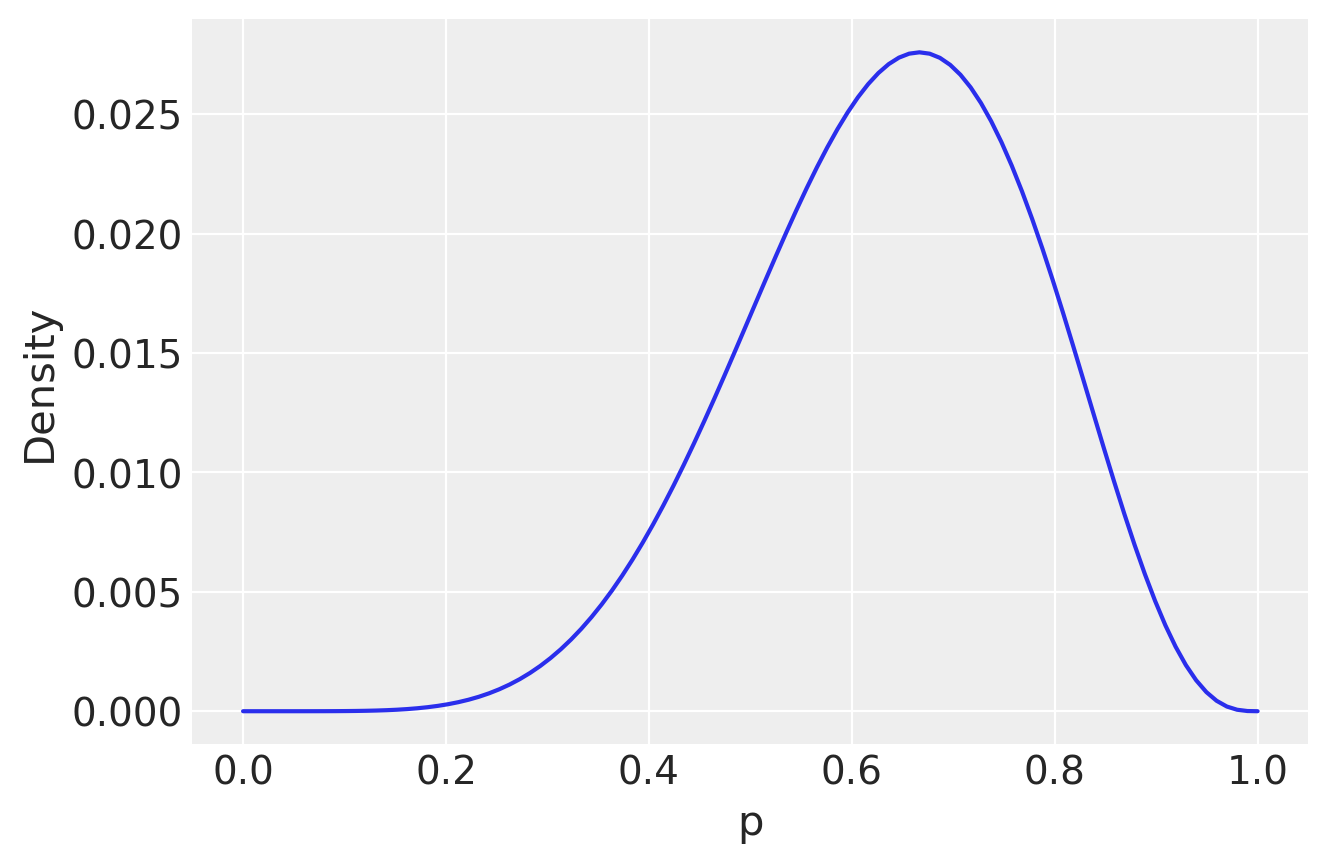

In [7]:
w, n = 6, 9
p_grid = np.linspace(0, 1, 100)
posterior = stats.binom.pmf(k=w, n=n, p=p_grid) * stats.uniform.pdf(p_grid, 0, 1)
posterior = posterior / (posterior).sum()
plt.plot(p_grid, posterior)
plt.xlabel('p')
plt.ylabel('Density');

#### Code 4.7 and 4.8

In [8]:
d = pd.read_csv('Data/Howell1.csv', sep=';', header=0)
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


#### Code 4.9

In [9]:
d.height.head()

0    151.765
1    139.700
2    136.525
3    156.845
4    145.415
Name: height, dtype: float64

#### Code 4.10

In [10]:
d2 = d[d.age >= 18]

#### Code 4.11

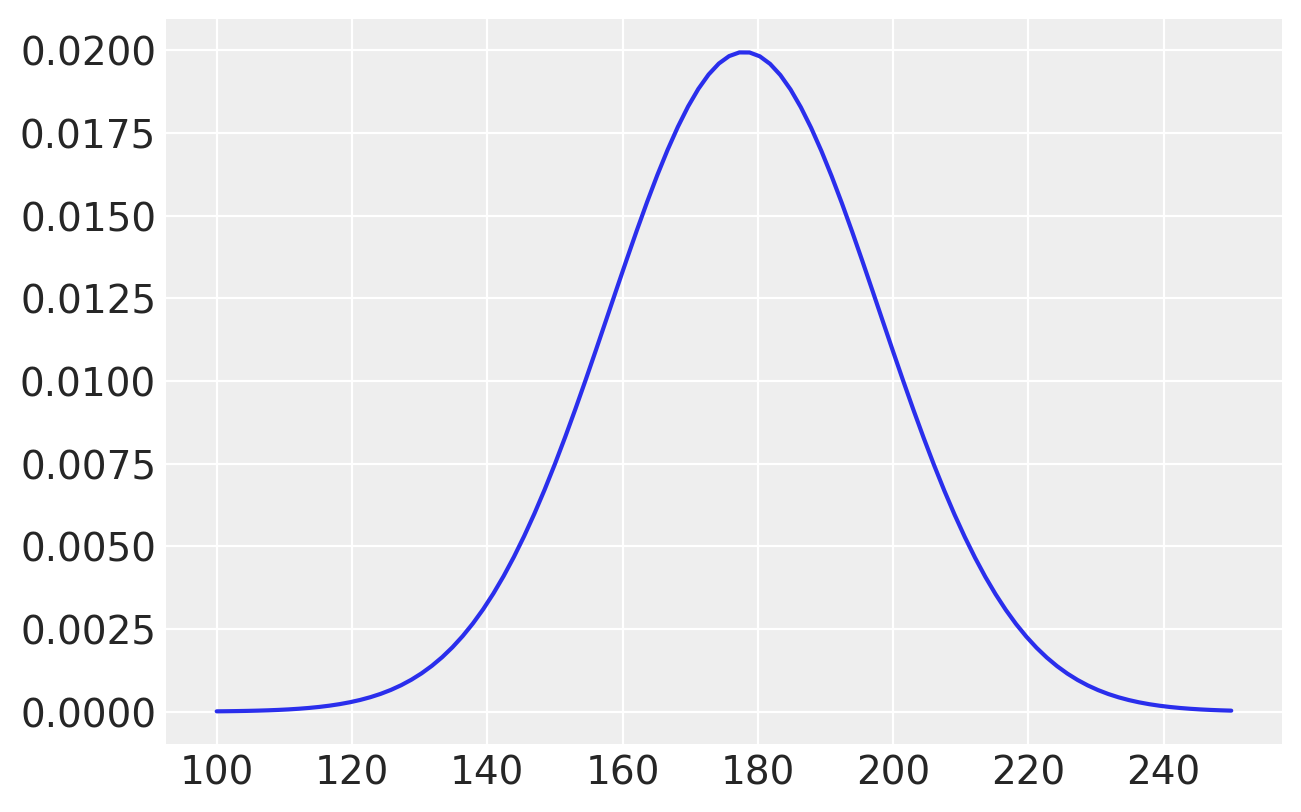

In [11]:
x = np.linspace(100, 250, 100)
plt.plot(x, stats.norm.pdf(x, 178, 20));

#### Code 4.12

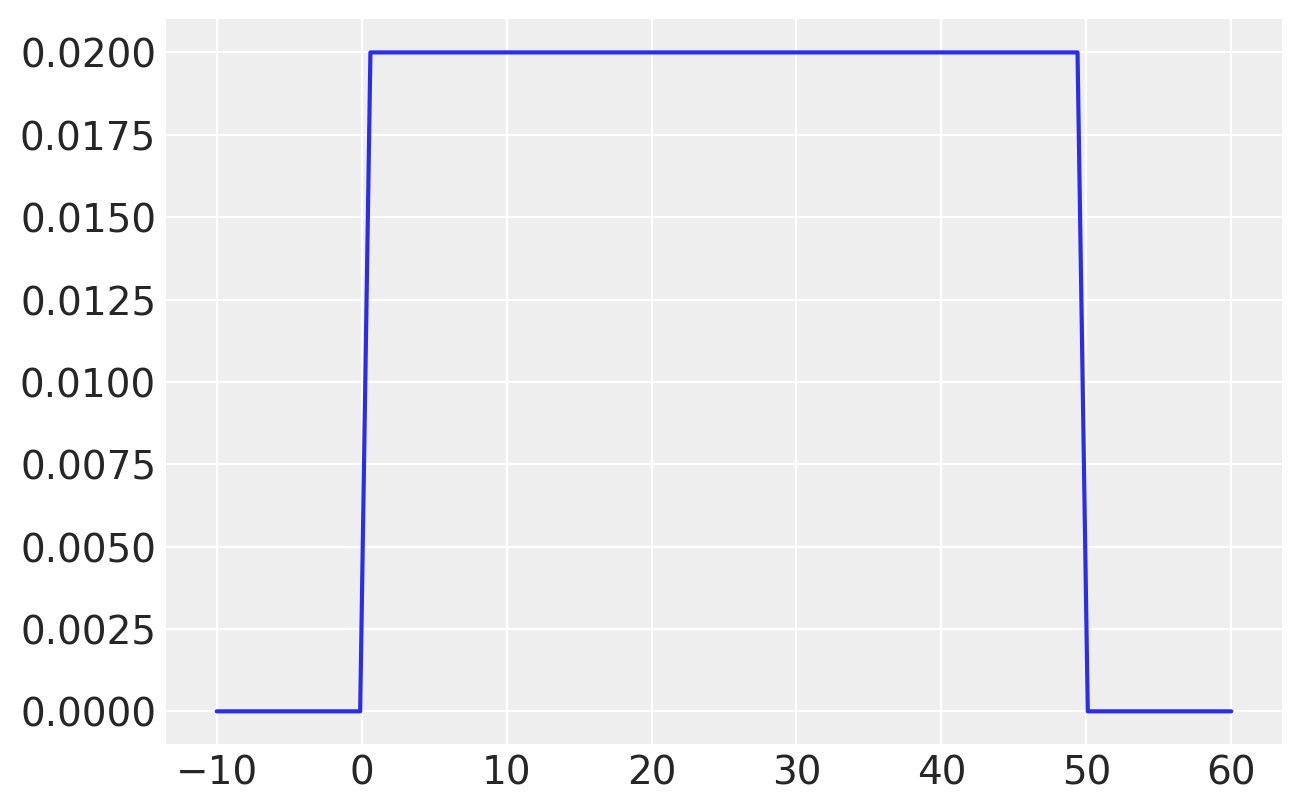

In [12]:
x = np.linspace(-10, 60, 100)
plt.plot(x, stats.uniform.pdf(x, 0, 50));

#### Code 4.13

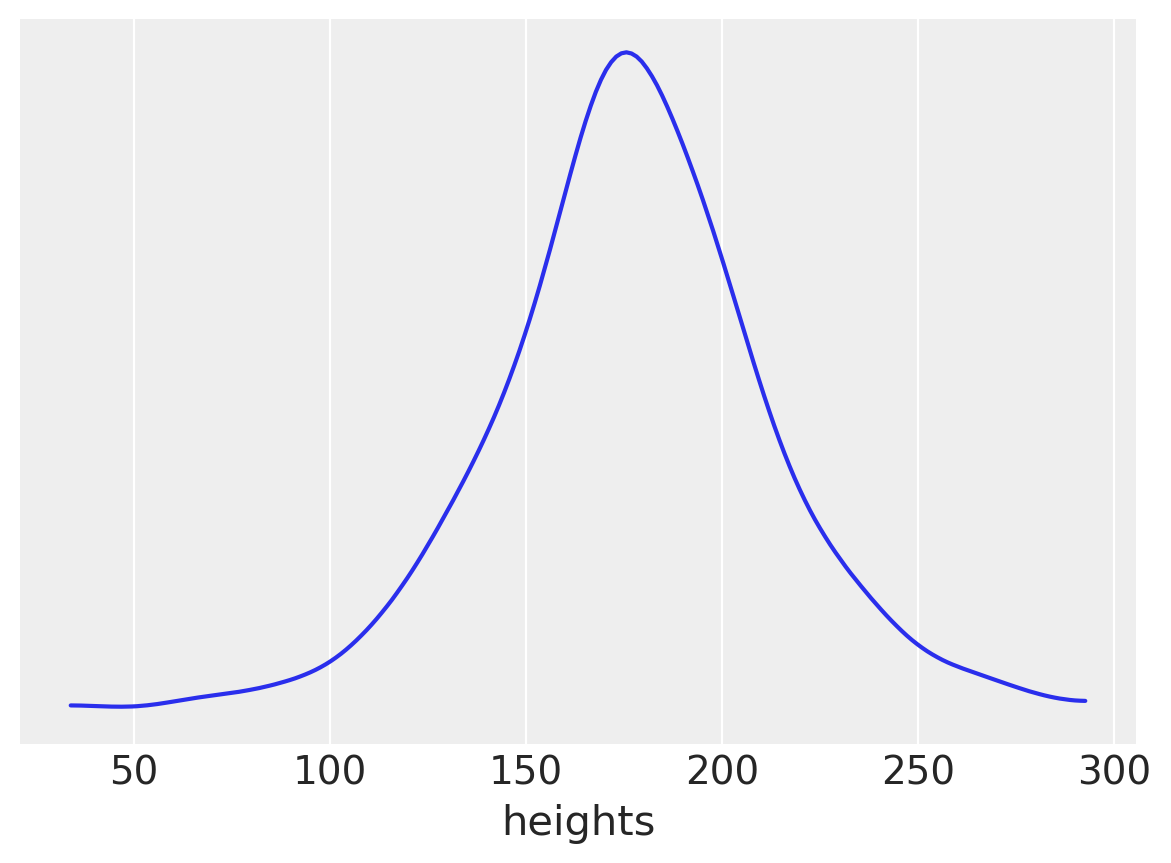

In [13]:
n_samples = 1000
sample_mu = stats.norm.rvs(loc=178, scale=20, size=n_samples)
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
az.plot_kde(prior_h)
plt.xlabel('heights')
plt.yticks([]);

#### Code 4.14

In [14]:
post = np.mgrid[140:160:0.1, 4:9:0.1].reshape(2,-1).T

likelihood = [sum(stats.norm.logpdf(d2.height, loc=post[:,0][i], scale=post[:,1][i])) for i in range(len(post))]

post_prod = (likelihood + 
             stats.norm.logpdf(post[:,0], loc=178, scale=20) + 
             stats.uniform.logpdf(post[:,1], loc=0, scale=50))
post_prob = np.exp(post_prod - max(post_prod))

#### Code 4.15 and 4.16

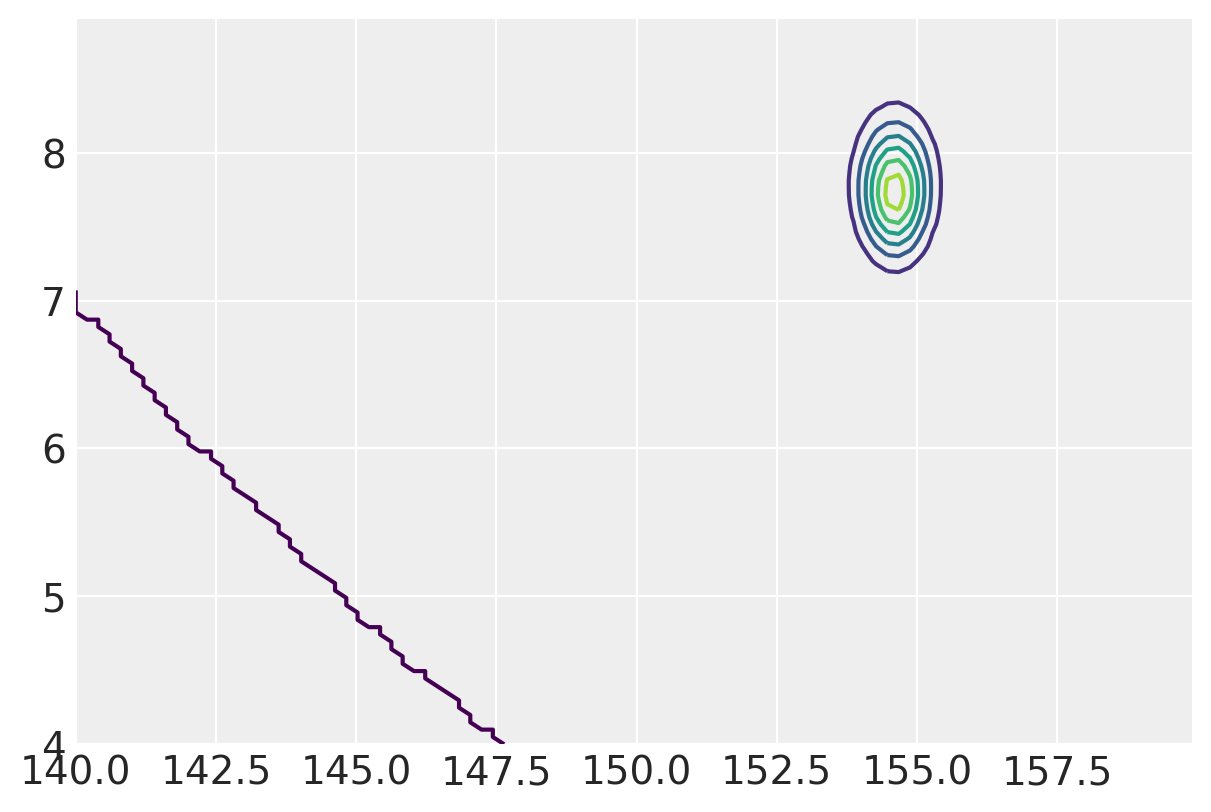

In [15]:
xi = np.linspace(post[:,0].min(), post[:,0].max(), 100)
yi = np.linspace(post[:,1].min(), post[:,1].max(), 100)
zi = griddata((post[:,0], post[:,1]), post_prob, (xi[None,:], yi[:,None]))

plt.contour(xi, yi, zi);

#### Code 4.17 and 4.18

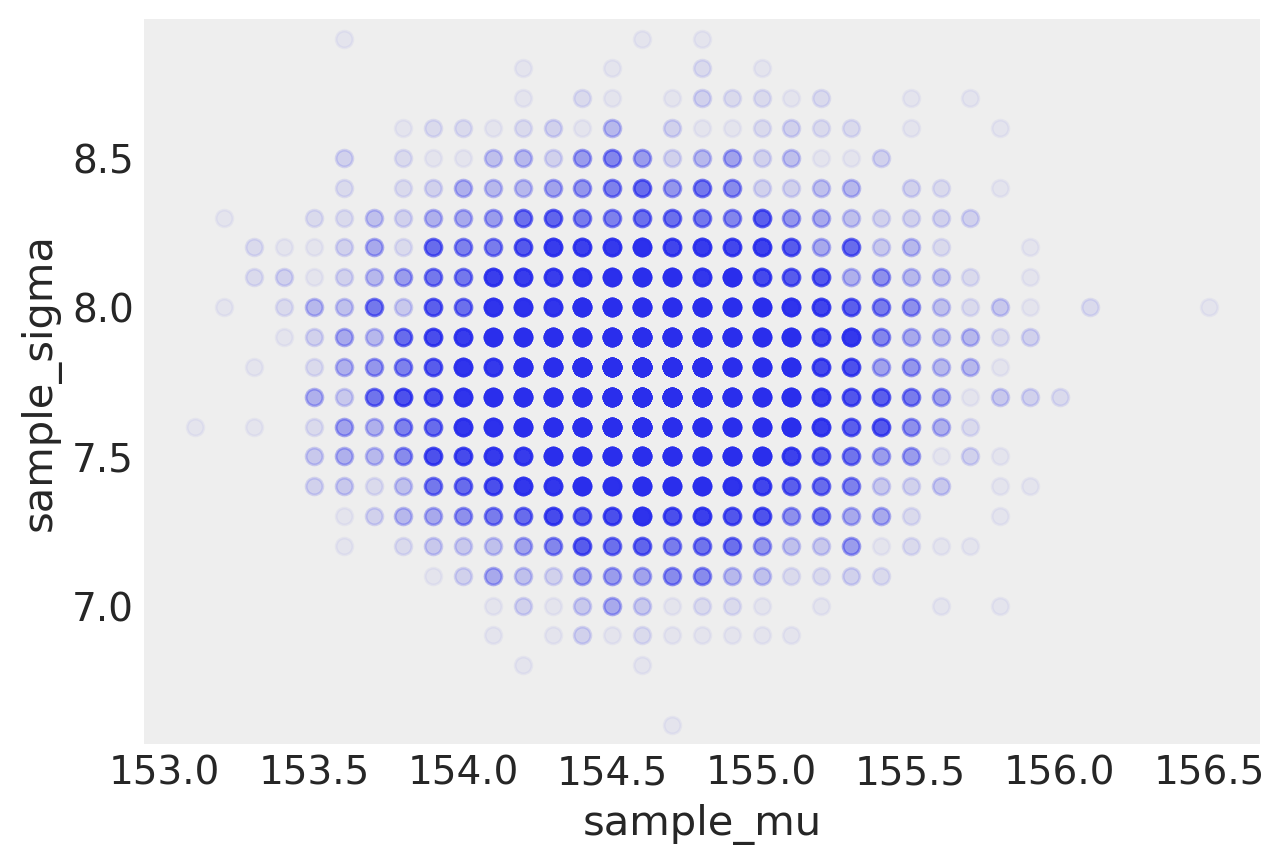

In [16]:
sample_rows = np.random.choice(np.arange(len(post)), size=10000, replace=True, 
                               p=(post_prob/post_prob.sum()))
sample_mu = post[:,0][sample_rows]
sample_sigma = post[:,1][sample_rows]

plt.plot(sample_mu, sample_sigma, 'o', alpha=0.05)
plt.axis('equal')
plt.grid(False)
plt.xlabel('sample_mu')
plt.ylabel('sample_sigma');

#### Code 4.19

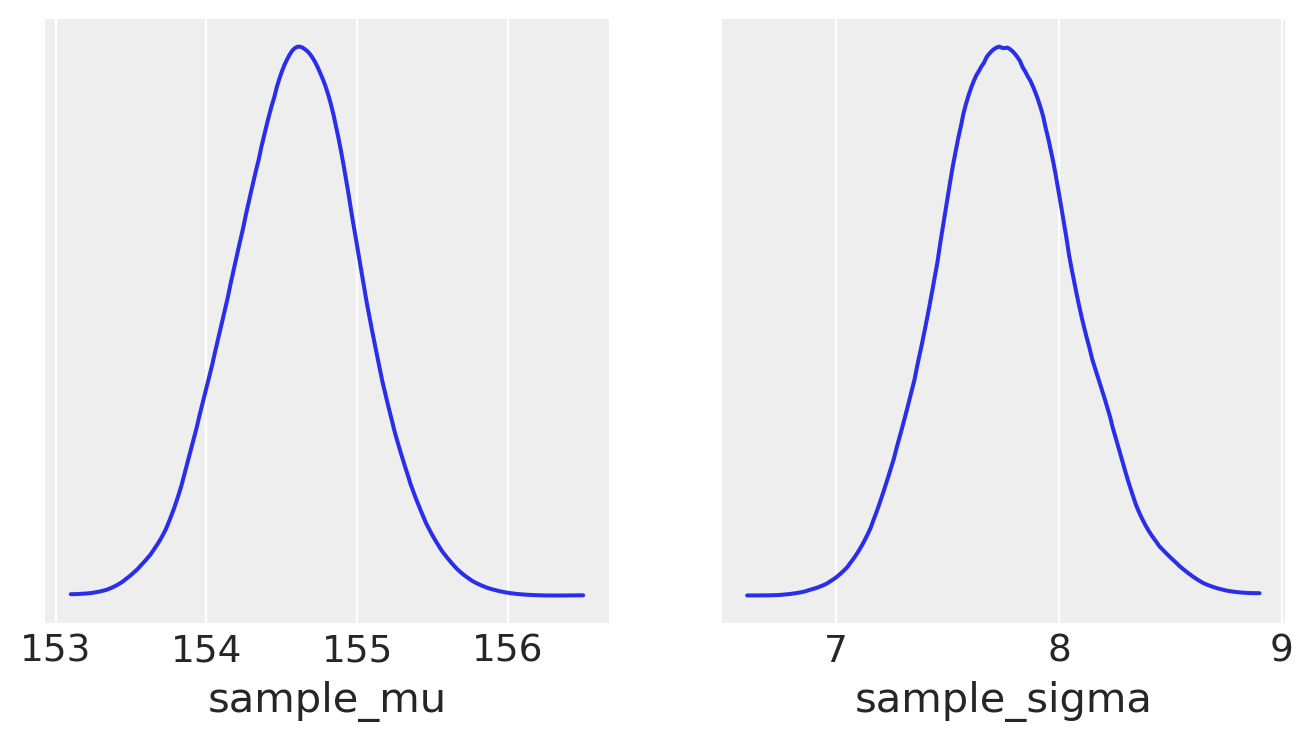

In [17]:
_, ax = plt.subplots(1,2, figsize=(8,4))
az.plot_kde(sample_mu, ax=ax[0])
ax[0].set_xlabel('sample_mu')
ax[0].set_yticks([])
az.plot_kde(sample_sigma, ax=ax[1])
ax[1].set_xlabel('sample_sigma')
ax[1].set_yticks([]);

#### Code 4.20

In [18]:
az.hpd(sample_mu), az.hpd(sample_sigma)

(array([153.8, 155.3]), array([7.1, 8.2]))

#### Code 4.21 and  4.22

In [19]:
d3 = np.random.choice(d2.height, 20)
post2 = np.mgrid[150:170:0.1, 4:20:0.1].reshape(2,-1).T

likelihood2 = [sum(stats.norm.logpdf(d3, loc=post2[:,0][i], scale=post2[:,1][i])) for i in range(len(post2))]

post_prod2 = (likelihood2 + 
              stats.norm.logpdf(post2[:,0], loc=178, scale=20) + 
              stats.uniform.logpdf(post2[:,1], loc=0, scale=50))

post_prob2 = np.exp(post_prod2 - max(post_prod2))

sample_rows2 = np.random.choice(np.arange(len(post2)), size=10000, replace=True, 
                               p=(post_prob2/post_prob2.sum()))
sample_mu2 = post2[:,0][sample_rows2]
sample_sigma2 = post2[:,1][sample_rows2]

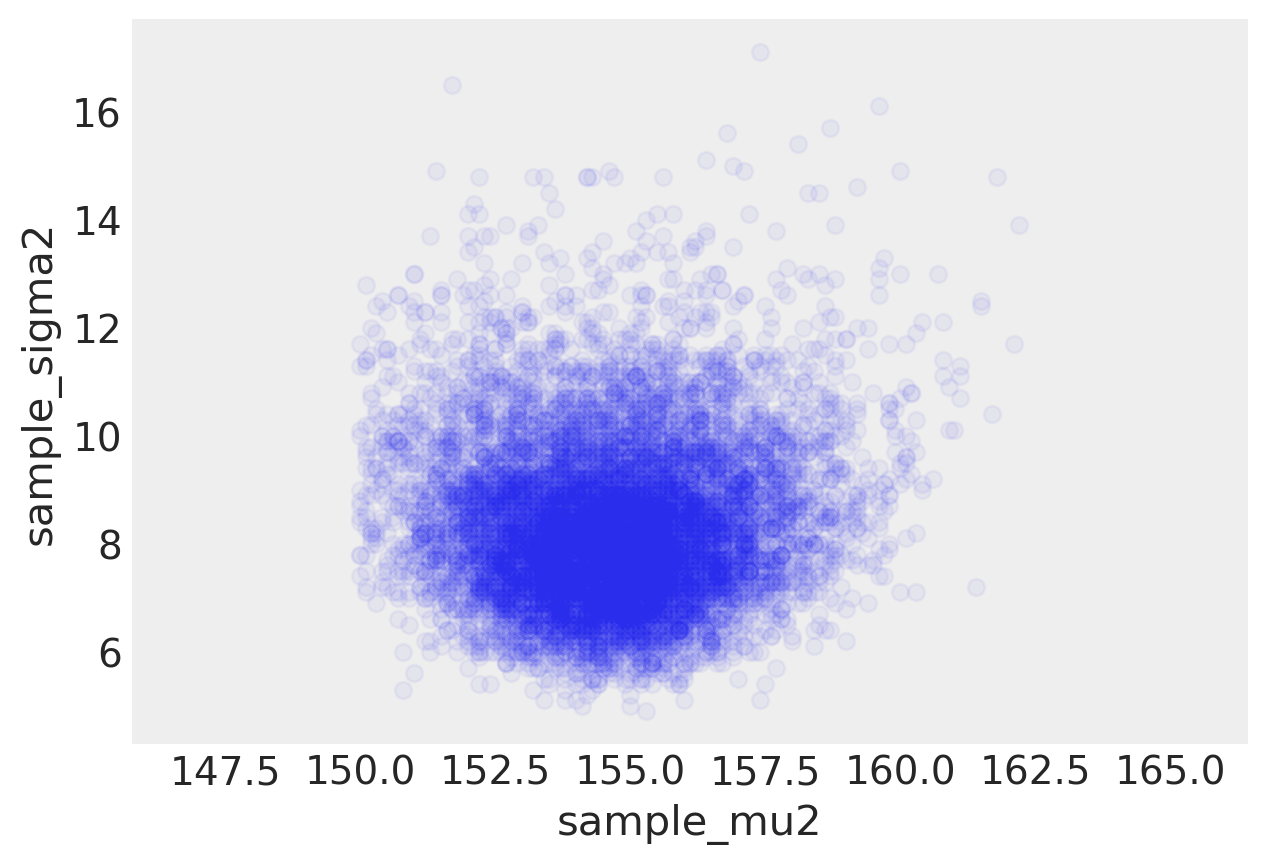

In [20]:
plt.plot(sample_mu2, sample_sigma2, 'o', alpha=0.05)
plt.axis('equal')
plt.xlabel('sample_mu2')
plt.ylabel('sample_sigma2')
plt.grid(False)

#### Code 4.23

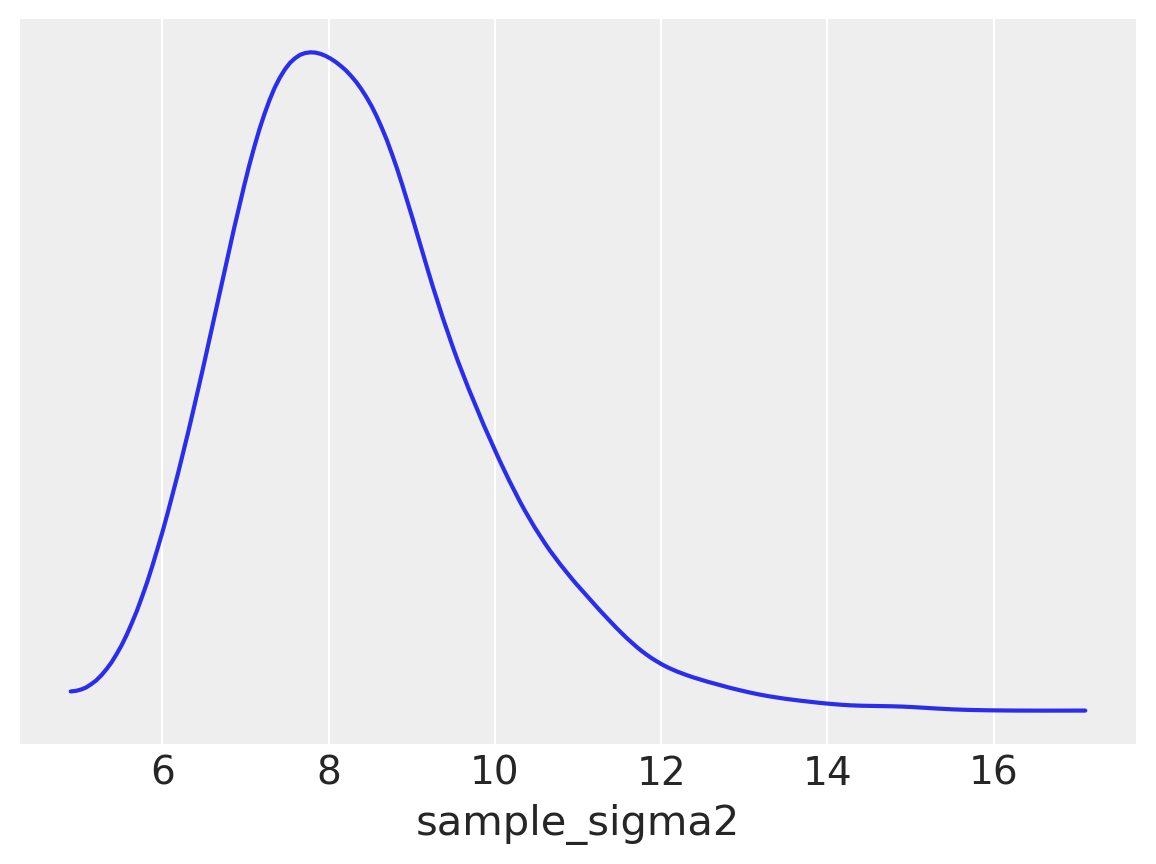

In [21]:
az.plot_kde(sample_sigma2)
plt.xlabel('sample_sigma2')
plt.yticks([]);

#### Code 4.24

We are repeating code 4.7, 4.8 and 4.10

In [22]:
d = pd.read_csv('Data/Howell1.csv', sep=';', header=0)
d2 = d[d.age >= 18]

#### Code 4.25

In [23]:
with pm.Model() as m4_1:
    mu = pm.Normal('mu', mu=178, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)

#### Code 4.26

We could use a quadratic approximation like McElreath does in his book and we did in code 2.6. But Using PyMC3 is really simple to just sample from the model using a "sampler method". Most common sampler methods are members of the Markov Chain Monte Carlo Method (MCMC) family (for details read Section 2.4.3 and Chapter 8 of Statistical Rethinking).

PyMC3 comes with various samplers. Some samplers are more suited than others for certain type of variable (and/or problems). For now we are going to let PyMC3 choose the sampler for us. PyMC3 also tries to provide a reasonable starting point for the simulation. By default PyMC3 uses the same adaptive procedure as in STAN `'jitter+adapt_diag'`, which start with a identity mass matrix and then adapt a diagonal based on the variance of the tuning samples. 

You can read more details of PyMC3 [here](http://pymc-devs.github.io/pymc3/notebooks/getting_started.html)

In [24]:
with m4_1:
    trace_4_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1780.78draws/s]


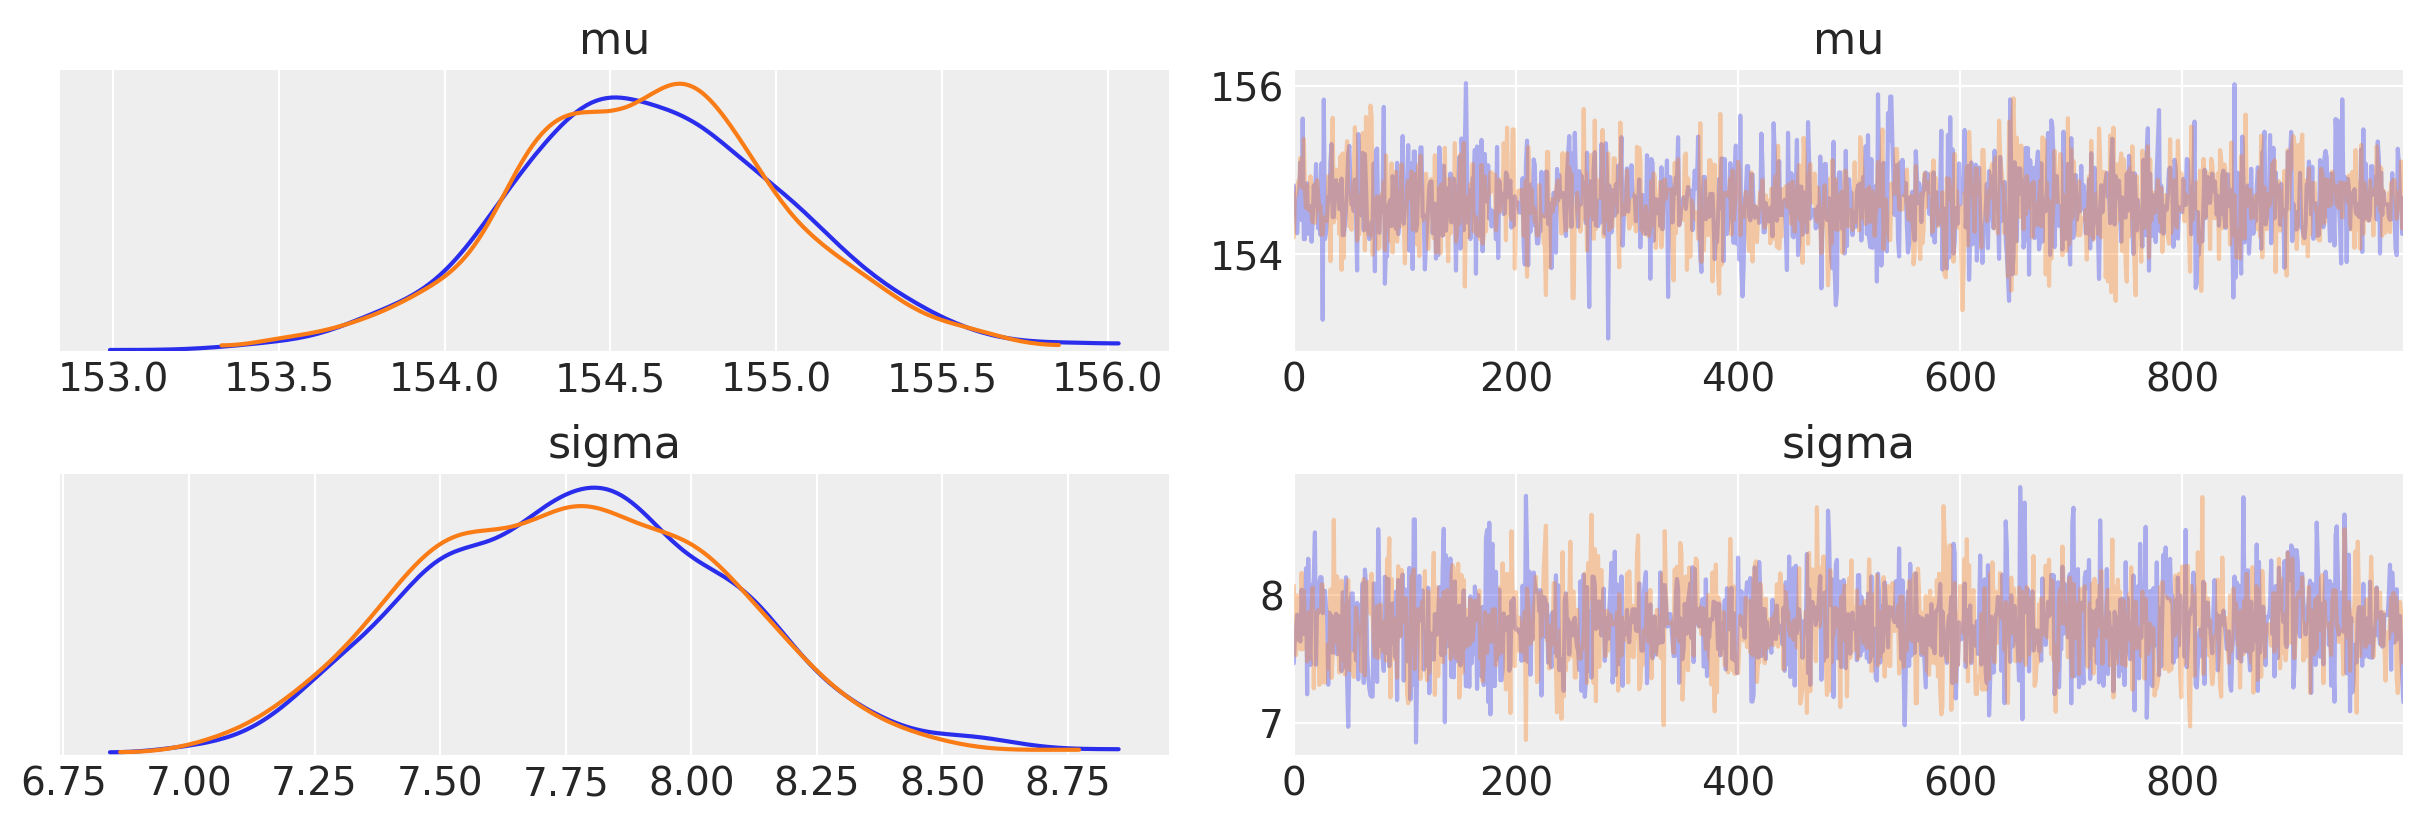

In [25]:
az.plot_trace(trace_4_1); # this function let you check the samples values

#### Code 4.27

Notice that compared to the table in the book we have an extra column, "mc_error". Since we are sampling from the posterior, there is an error introducing by the sampling process. This error can be reduced by taking more samples.

In [26]:
az.summary(trace_4_1, credible_interval=.89).round(2)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,154.62,0.42,153.95,155.28,0.01,0.01,2137.0,2137.0,2139.0,1197.0,1.0
sigma,7.77,0.31,7.28,8.23,0.01,0.00,2097.0,2097.0,2134.0,1113.0,1.0


#### Code 4.28

In [27]:
with pm.Model() as m4_1:
    mu = pm.Normal('mu', mu=178, sd=20, testval=d2.height.mean())
    sigma = pm.Uniform('sigma', lower=0, upper=50, testval=d2.height.std())
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1413.52draws/s]


,mean,sd,hpd_44.5%,hpd_55.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,154.61,0.41,154.60,154.70,0.01,0.01,1988.0,1987.0,2008.0,1463.0,1.0
sigma,7.77,0.29,7.75,7.83,0.01,0.00,1812.0,1812.0,1794.0,1397.0,1.0


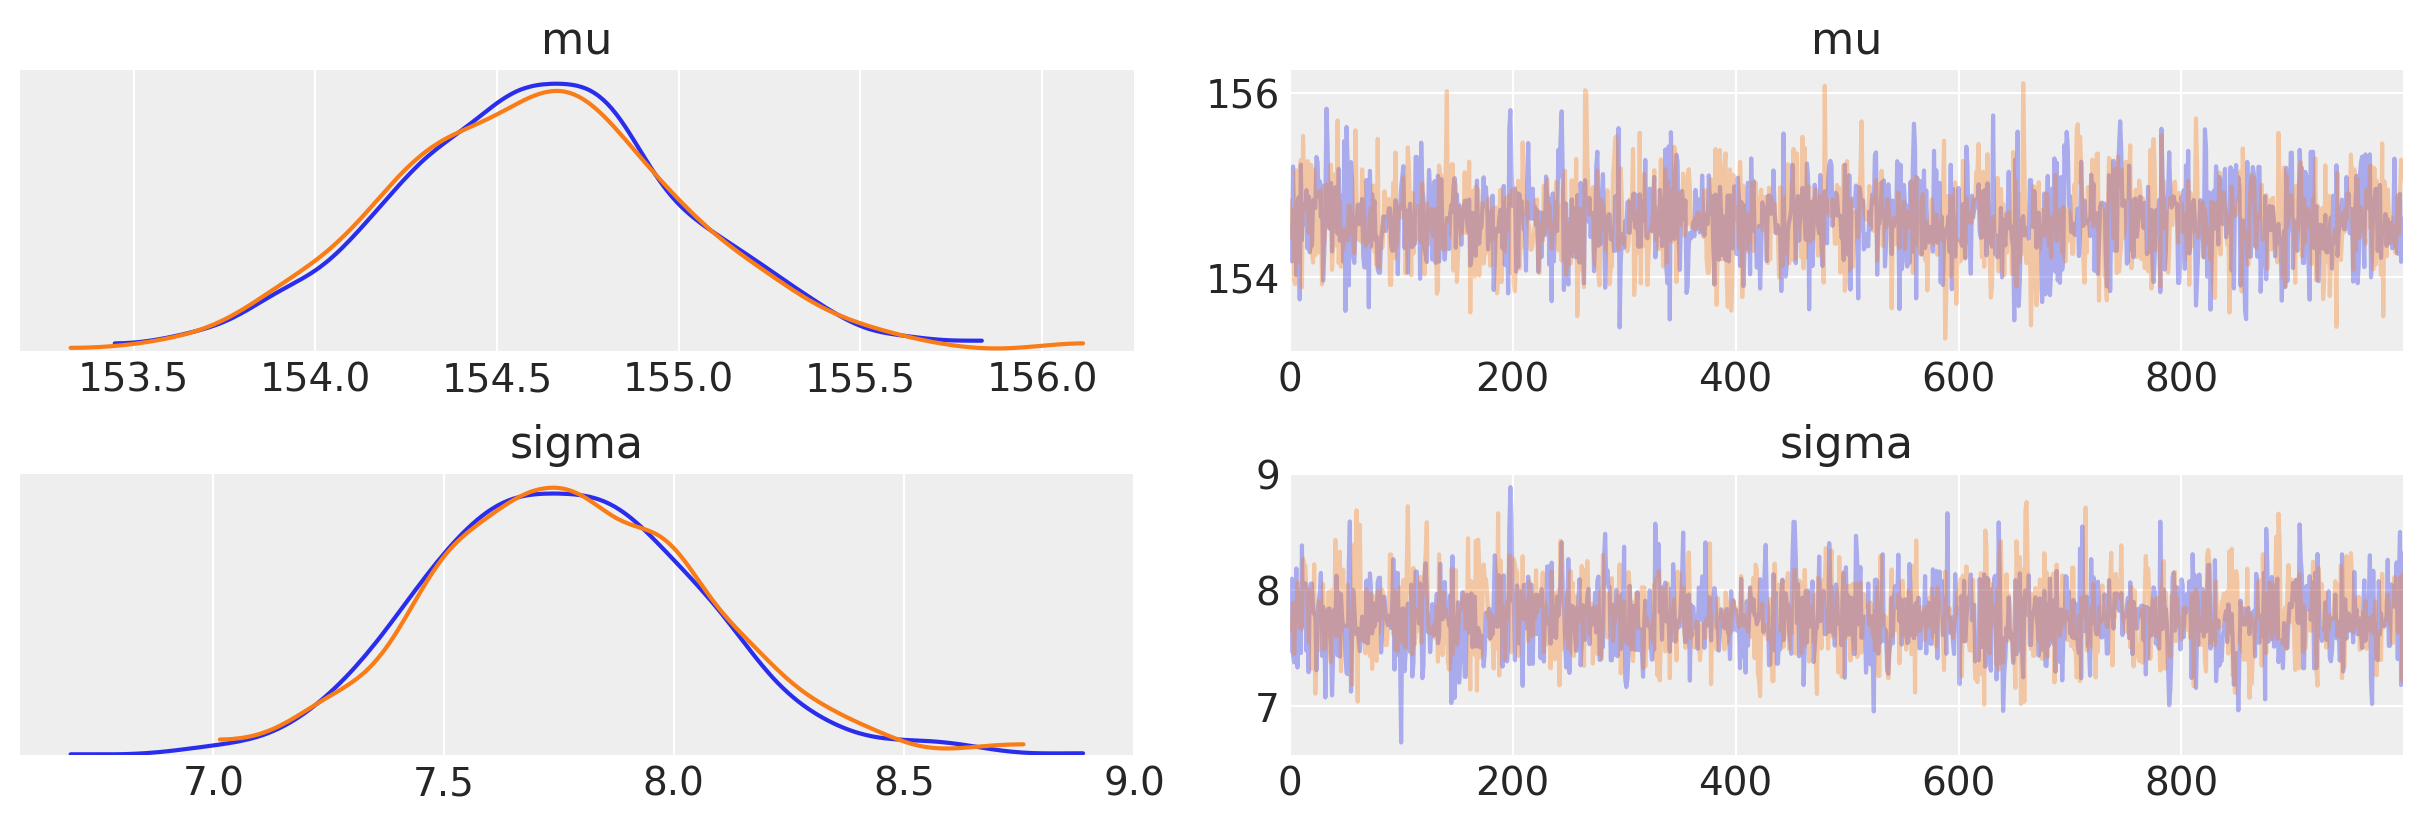

In [28]:
az.plot_trace(trace_4_1); 
az.summary(trace_4_1, credible_interval=.11).round(2)

#### Code 4.29

In [29]:
with pm.Model() as m4_2:
    mu = pm.Normal('mu', mu=178, sd=0.1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1730.24draws/s]


In [30]:
y = np.array([1, 2, 3, 4])
with pm.Model() as model:
    N = pm.DiscreteUniform('N', lower=y.max(), upper=y.max()*20)
    y_obs = pm.DiscreteUniform('y', lower=0, upper=N, observed=y)

    trace = pm.sample(10000)

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [N]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:03<00:00, 6622.35draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [31]:
az.summary(trace_4_2, credible_interval=.89).round(2)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,177.86,0.10,177.70,178.02,0.00,0.00,2191.0,2191.0,2184.0,1386.0,1.0
sigma,24.60,0.95,23.18,26.19,0.02,0.02,2042.0,2031.0,2058.0,1217.0,1.0


#### Code 4.30

For some computations could be nice to have the trace turned into a DataFrame, this can be done using the `trace_to_dataframe` function

In [32]:
trace_df = pm.trace_to_dataframe(trace_4_1)
trace_df.cov()

,mu,sigma
mu,0.165586,-0.001541
sigma,-0.001541,0.084869


#### Code 4.31

In [33]:
np.diag(trace_df.cov())

array([0.16558594, 0.08486888])

In [34]:
trace_df.corr()

,mu,sigma
mu,1.000000,-0.012996
sigma,-0.012996,1.000000


#### Code 4.32

We did not use the quadratic approximation, instead we use a MCMC method to sample from the posterior. Thus, we already have samples. We can do something like

In [35]:
trace_df.head()

,mu,sigma
0,154.563707,7.479648
1,154.421449,7.486344
2,154.167424,8.100409
3,155.202806,7.450744
4,154.540471,7.380200


Or directly from the trace (we are getting the first ten samples of _sigma_)

In [36]:
trace_4_1['sigma'][:10]

array([7.47964844, 7.48634416, 8.10040924, 7.45074388, 7.38019987,
       7.65492714, 8.1882084 , 7.33572174, 7.60897717, 8.00052133])

#### Code 4.33

In our case, this is the same we did in the code 4.27

In [37]:
az.summary(trace_4_1, credible_interval=.89).round(2)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,154.61,0.41,153.92,155.22,0.01,0.01,1988.0,1987.0,2008.0,1463.0,1.0
sigma,7.77,0.29,7.32,8.23,0.01,0.00,1812.0,1812.0,1794.0,1397.0,1.0


#### Code 4.34

In [38]:
stats.multivariate_normal.rvs(mean=trace_df.mean(), cov=trace_df.cov(), size=10)

array([[155.06541323,   7.36976044],
       [154.80070039,   7.52428971],
       [154.72668142,   8.04596424],
       [154.28914186,   7.9272142 ],
       [154.58863427,   7.81638416],
       [154.70786142,   7.41644263],
       [154.13404961,   7.73487825],
       [154.91903452,   7.32931903],
       [154.83379427,   7.22095491],
       [154.59565877,   7.4875958 ]])

#### Code 4.35 and 4.36

Instead of sampling from a normal and then exponentiating to ensure sigma is positive, we can use the lognormal distribution for the same result. The Lognormal distribution is parametrized in terms of $\tau$ (tau) the precision and not the standard deviation, where: 

$$tau=\frac{1}{\sigma^2}$$

The normal distribution can also be parametrized in terms of the precision (tau). Given that the conversion between both parametrization is done right, which one to use is only a matter of convenience. 

In [39]:
with pm.Model() as m4_1_logsigma:
    mu = pm.Normal('mu', mu=178, sd=20)
    sigma = pm.Lognormal('sigma', mu=2, tau=0.01)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_1_logsigma = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1519.30draws/s]


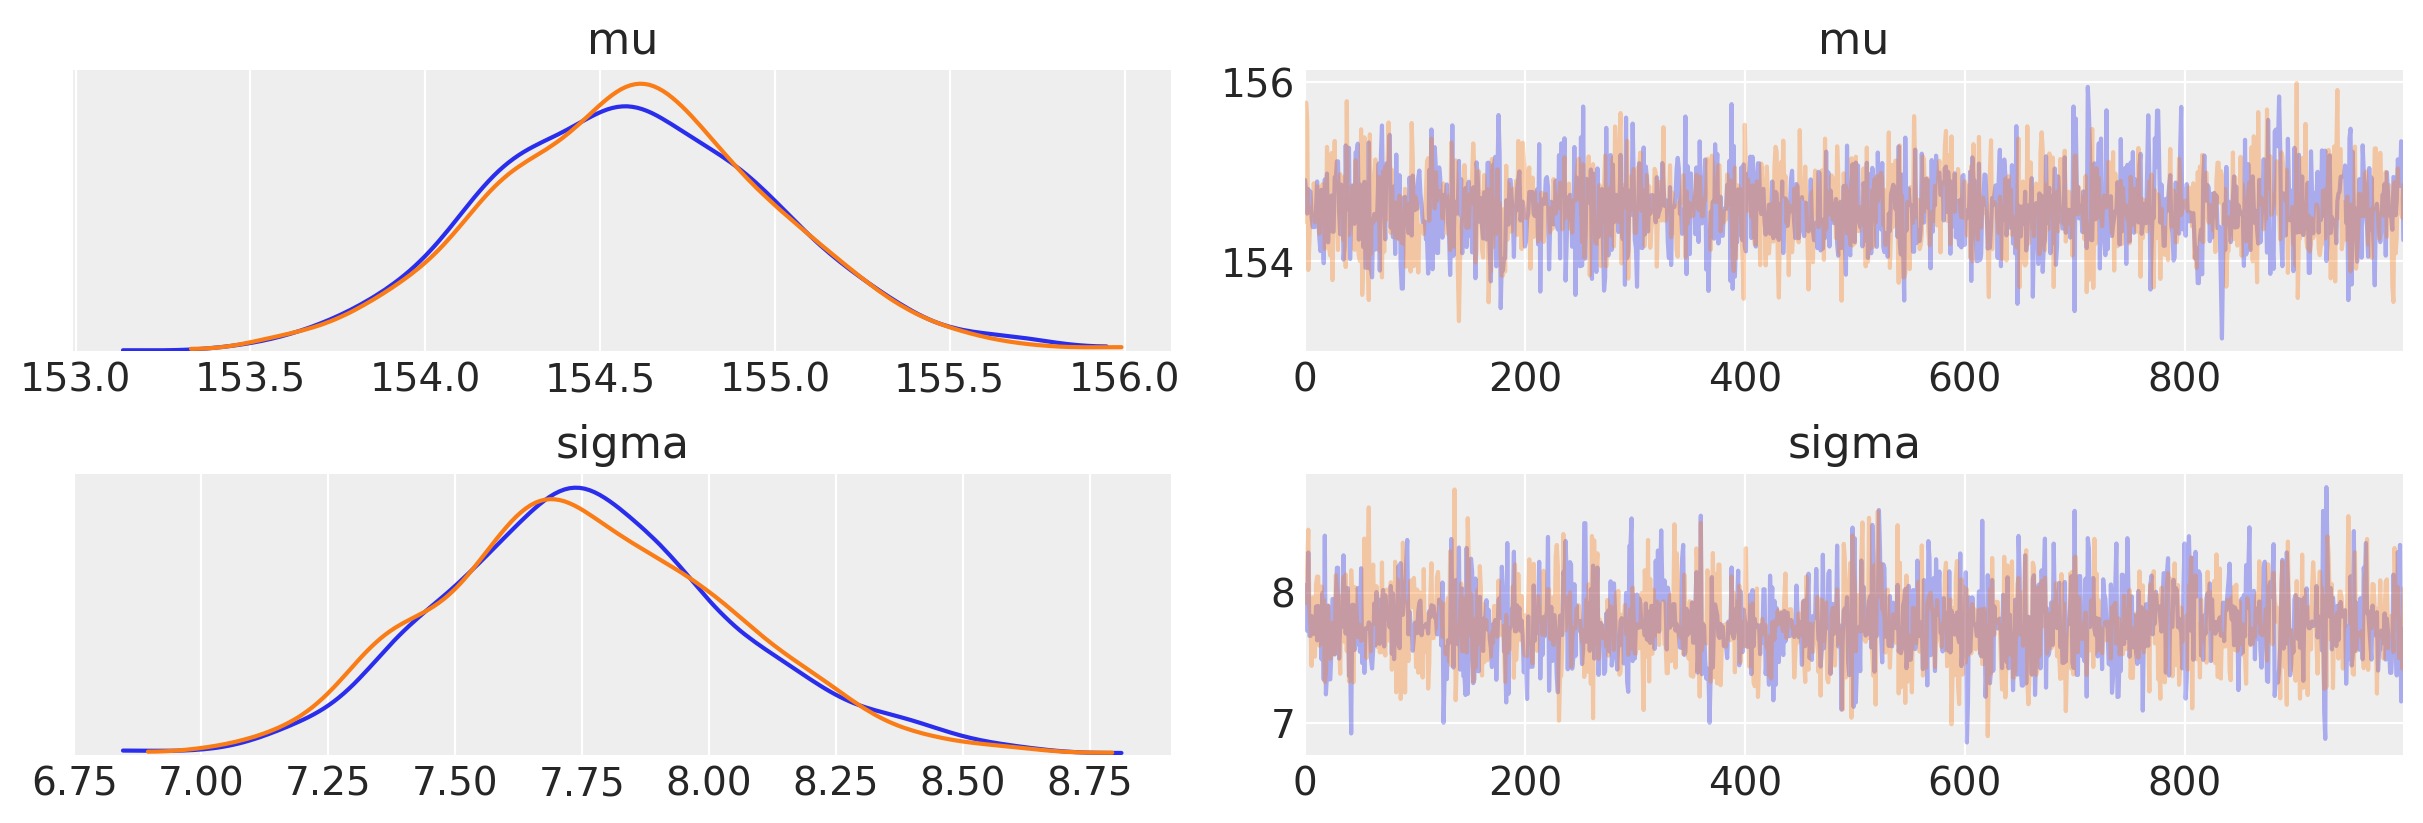

In [40]:
az.plot_trace(trace_4_1_logsigma);

#### Code 4.37

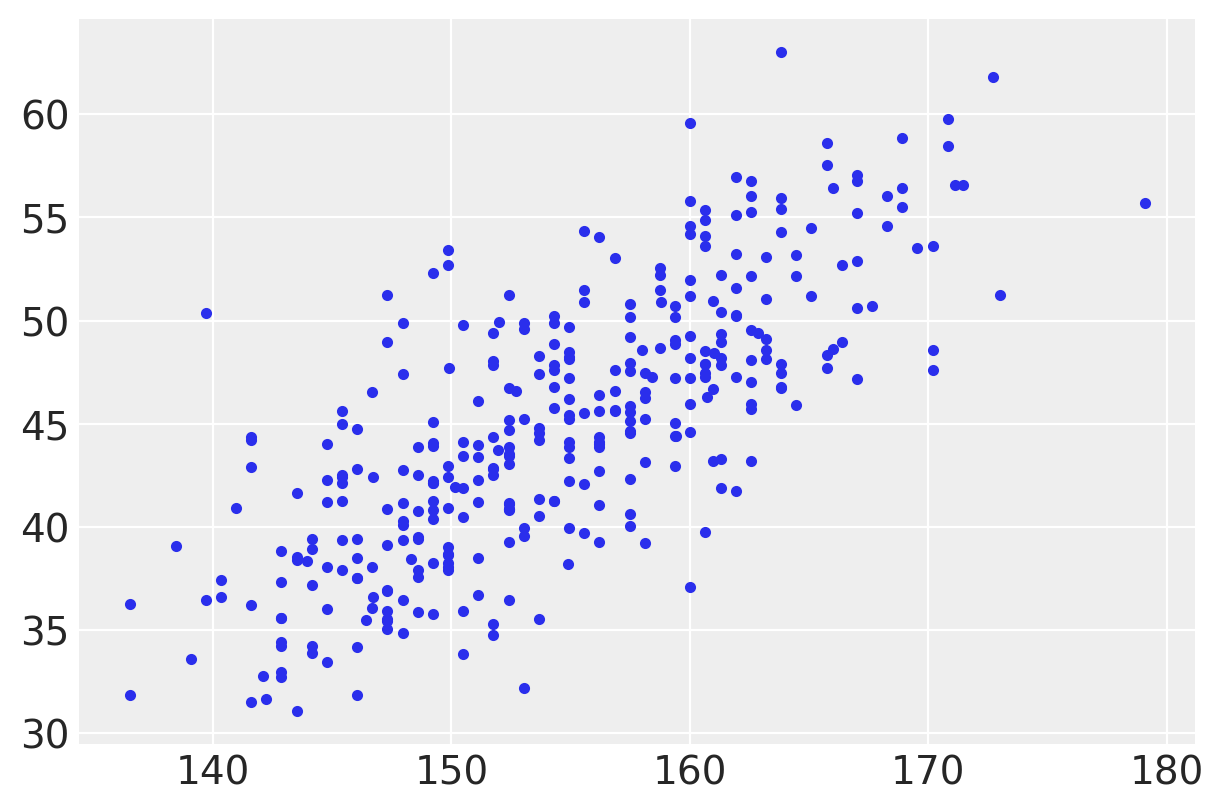

In [41]:
plt.plot(d2.height, d2.weight, '.');

#### Code 4.38 and 4.39

Notice that the variable mu is defined as alpha + beta * d2.weight in a single line. If we want the trace to contain mu we can write as a deterministic varible. The computating will be exactly the same. The only difference is that mu will be accessible in the trace.

In [71]:
with pm.Model() as m4_3:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = alpha + beta * d2.weight
    #mu = pm.Deterministic('mu', alpha + beta * d2.weight) # try uncomenting this line and comenting the above line
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    
    trace_4_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:09<00:00, 413.12draws/s]


In [ ]:
az.plot_trace(trace_4_3);
#trace_4_3.get_values('mu')

/home/will/anaconda3/envs/learn-env/lib/python3.6/site-packages/arviz/plots/traceplot.py:156: SyntaxWarning: max_plots is smaller than the number of variables to plot generating only max_plots traceplots
  SyntaxWarning,


Another alternative is to write mu inside the likelihood and not as a separate line.

    height = pm.Normal('height', mu=alpha + beta * d2.weight, sd=sigma, observed=d2.height)
    
Using PyMC3 there is not too much reason to do this. I personally think that defining mu in a separate line improves readability.

#### Code 4.40

In [44]:
az.summary(trace_4_3, credible_interval=.11).round(2)

,mean,sd,hpd_44.5%,hpd_55.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,113.82,2.01,113.97,114.45,0.08,0.05,681.0,679.0,694.0,483.0,1.0
beta,0.91,0.04,0.89,0.90,0.00,0.00,693.0,693.0,702.0,560.0,1.0
sigma,5.11,0.19,5.04,5.09,0.01,0.00,1014.0,1014.0,1013.0,1042.0,1.0


#### Code 4.41

In [45]:
trace_df = pm.trace_to_dataframe(trace_4_3)
trace_df.corr().round(2)

,alpha,beta,sigma
alpha,1.00,-0.99,-0.09
beta,-0.99,1.00,0.09
sigma,-0.09,0.09,1.00


#### Code 4.42

In [46]:
d2 = d2.assign(weight_c=pd.Series(d2.weight - d2.weight.mean()))

#### Code 4.43

In [47]:
with pm.Model() as m4_4:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = alpha + beta * d2.weight_c
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_4 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1389.36draws/s]


#### Code 4.44

In [48]:
az.summary(trace_4_4, credible_interval=.89).round(3)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,154.604,0.274,154.192,155.048,0.005,0.004,2986.0,2986.0,2968.0,1478.0,1.0
beta,0.906,0.042,0.842,0.978,0.001,0.001,3336.0,3298.0,3350.0,1549.0,1.0
sigma,5.102,0.202,4.785,5.433,0.004,0.003,2802.0,2730.0,2844.0,1405.0,1.0


#### Code 4.45

Instead of using the MAP, we are going to use the mean of the posterior 

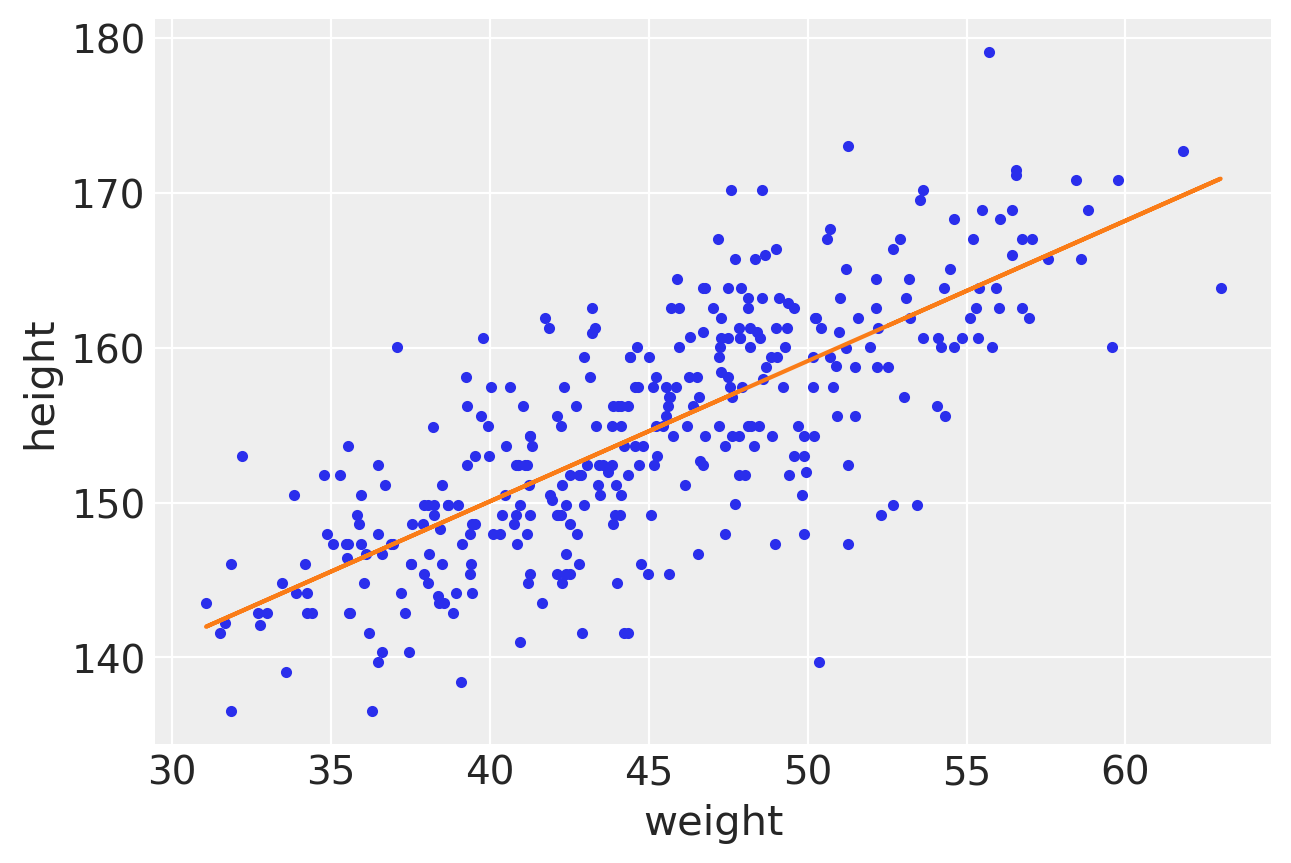

In [49]:
plt.plot(d2.weight, d2.height, '.')
plt.plot(d2.weight, trace_4_3['alpha'].mean() + trace_4_3['beta'].mean() * d2.weight)
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0]);

#### Code 4.46 and 4.47

In [50]:
pm.trace_to_dataframe(trace_4_4)[:5]

,alpha,beta,sigma
0,154.912919,0.891523,5.169315
1,154.107770,0.938088,5.156243
2,154.638949,0.857767,5.105010
3,154.638383,0.899250,5.010115
4,154.477940,0.944940,5.132302


#### Code 4.48

In [51]:
N = [10, 50, 150, 352][0]
with pm.Model() as m_N:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta * d2.weight[:N])
    height_hat = pm.Normal('height_hat', mu=mu, sd=sigma, observed=d2.height[:N])
    trace_N = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:06<00:00, 592.79draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


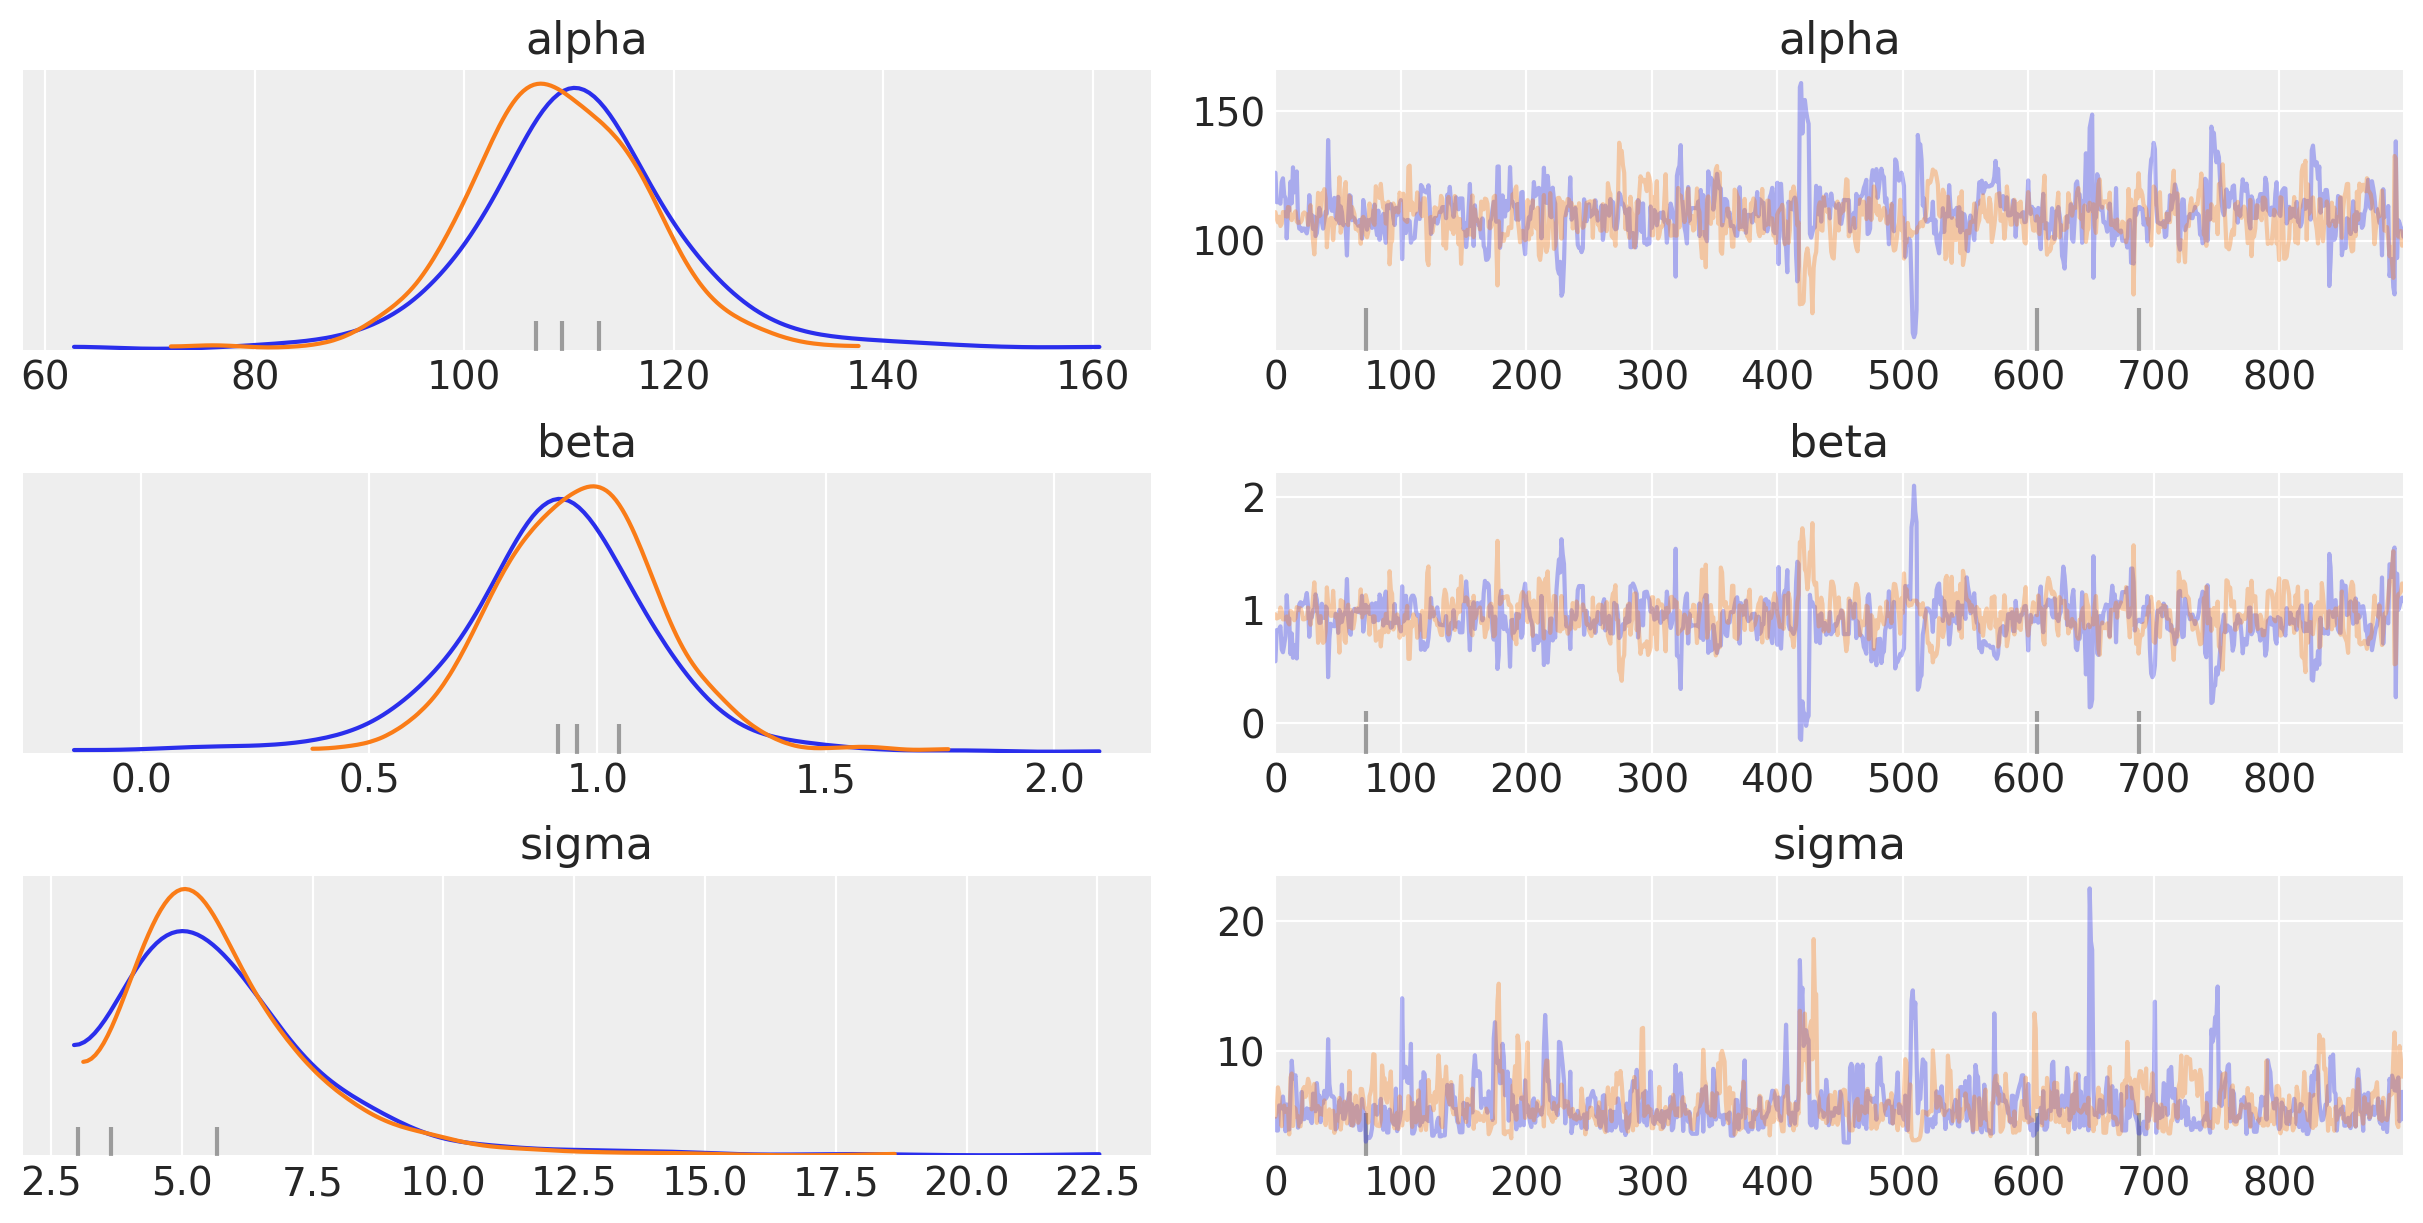

In [52]:
chain_N = trace_N[100:]
az.plot_trace(chain_N, var_names='~mu');

#### Code 4.49

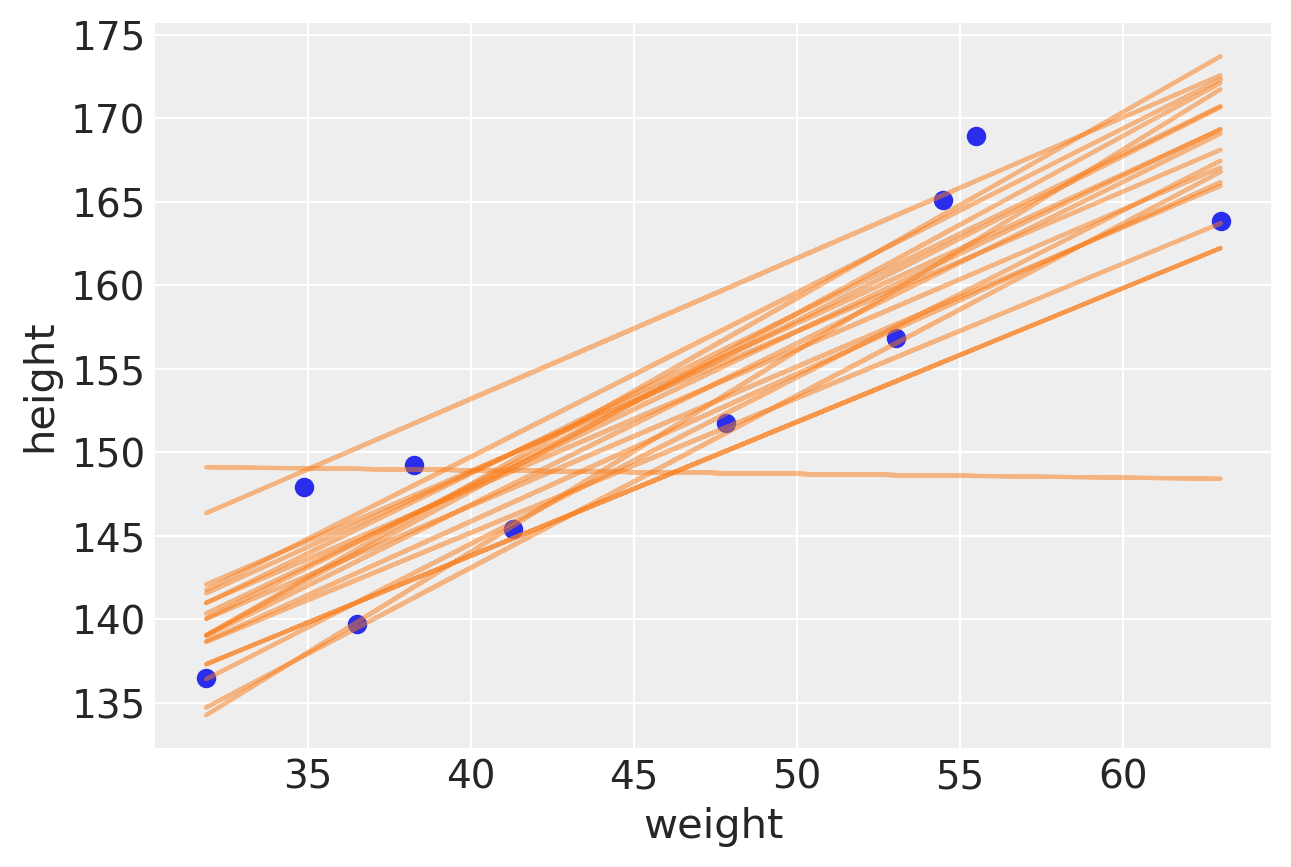

In [53]:
plt.plot(d2.weight[:N], d2.height[:N], 'C0o')
for _ in range(0, 20):
    idx = np.random.randint(len(chain_N))
    plt.plot(d2.weight[:N], chain_N['alpha'][idx] + chain_N['beta'][idx] * d2.weight[:N], 'C1-', alpha=0.5)
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0]);

Alternative we can directly use the deterministic mu variable

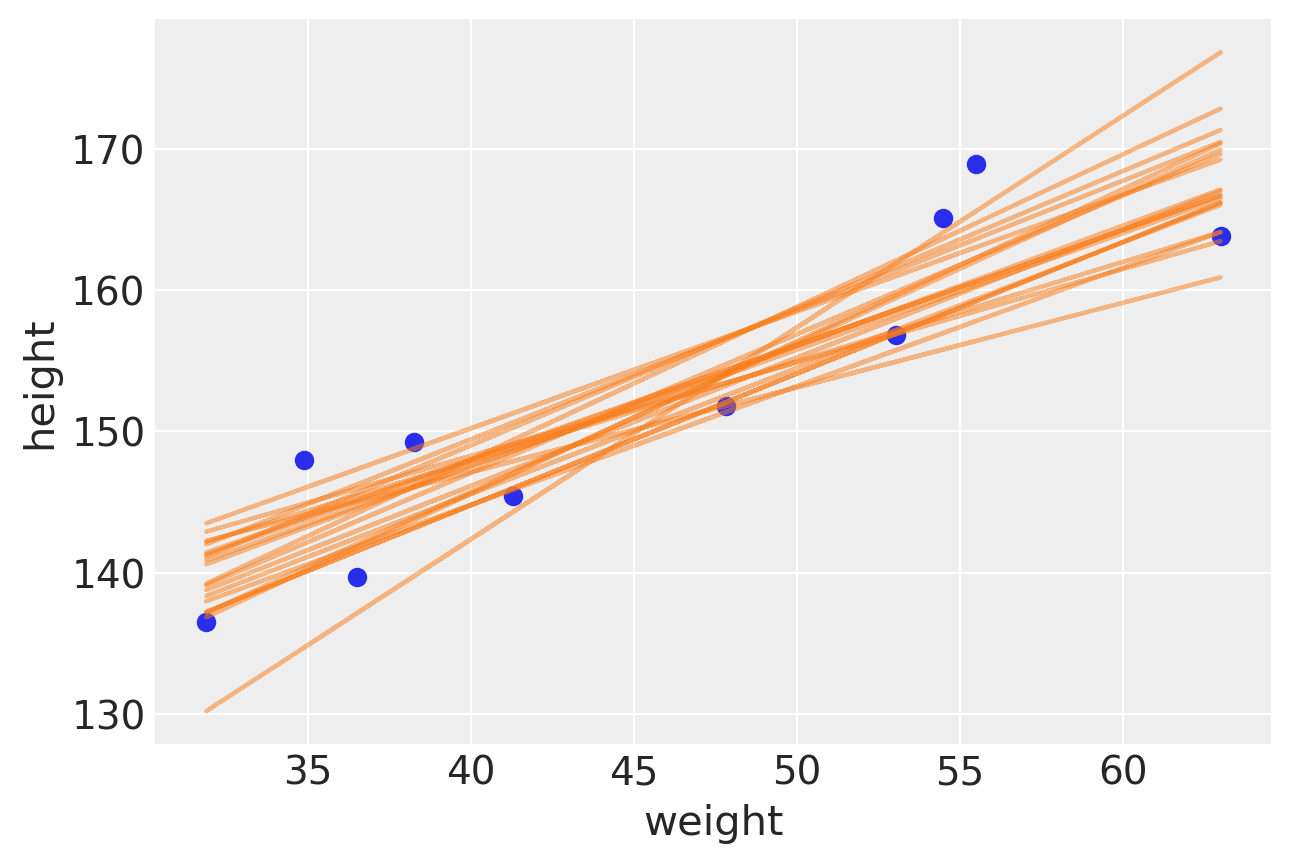

In [54]:
plt.plot(d2.weight[:N], d2.height[:N], 'C0o')
for _ in range(0, 20):
    idx = np.random.randint(len(chain_N))
    plt.plot(d2.weight[:N], chain_N['mu'][idx], 'C1-', alpha=0.5)
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0]);

#### Code 4.50 and 4.51

In [55]:
mu_at_50= 
az.plots.kdeplot(mu_at_50)
plt.xlabel('heights')
plt.yticks([]);

SyntaxError: invalid syntax (<ipython-input-55-3edf5c0a4aa8>, line 1)

#### Code 4.52

In [ ]:
az.hpd(mu_at_50, credible_interval=.89)

#### Code 4.53

Using PyMC3, we do not need to compute anything else. By defining a deterministic variable mu in the model, we add that variable to the trace. Thus we get a matrix with row samples from the posterior and columns values of weights. We can access this matrix directly from the trace or turn it into a DataFrame, it all depends on what we need.

In [ ]:
df_trace_N = pm.trace_to_dataframe(chain_N).filter(regex=('mu.*'))
df_trace_N.head()

#### Code 4.54 and 4.58

We are doing _manually_, in the book is done using the ```link``` function. In the book on code 4.58 the following operations are performed _manually_.

In [ ]:
weight_seq = np.arange(25, 71)
# Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
chain_N_thinned = chain_N[::10]
mu_pred = np.zeros((len(weight_seq), len(chain_N_thinned)*chain_N.nchains))
for i, w in enumerate(weight_seq):
    mu_pred[i] = chain_N_thinned['alpha'] + chain_N_thinned['beta'] * w

#### Code 4.55

In [ ]:
plt.plot(weight_seq, mu_pred, 'C0.', alpha=0.1)
plt.xlabel('weight')
plt.ylabel('height');

#### Code 4.56

In [ ]:
mu_mean = mu_pred.mean(1)
mu_hpd = az.hpd(mu_pred.T, credible_interval=.89)

#### Code 4.57

In [ ]:
plt.scatter(d2.weight[:N], d2.height[:N])
plt.plot(weight_seq, mu_mean, 'k')
az.plot_hpd(weight_seq, mu_pred.T)
plt.xlabel('weight')
plt.ylabel('height')
plt.xlim(d2.weight[:N].min(), d2.weight[:N].max());

#### Code 4.59

Now we are going to use ```sample_ppc()``` from PyCM3. This function give us posterior predictive samples, that is for each value of the input variable we get the a sample (from the posterior) of the output variable. Thus in the following example the shape of height_pred['height_hat'].shape is (200, 352)

In [ ]:
height_pred = pm.sample_posterior_predictive(chain_N, 200, m_N)

#### Code 4.60

In [ ]:
height_pred_hpd = az.hpd(height_pred['height_hat'])

#### Code 4.61

In [ ]:
plt.scatter(d2.weight[:N], d2.height[:N])
az.plot_hpd(weight_seq, mu_pred.T)
az.plot_hpd(d2.weight[:N], height_pred['height_hat'])
plt.plot(weight_seq, mu_mean, 'k')
plt.xlabel('weight')
plt.ylabel('height')
plt.xlim(d2.weight[:N].min(), d2.weight[:N].max());

#### Code 4.62

Change the number of samples used in 4.59 (200) to other values. Because we are getting samples at the input values the jaggedness of this plot is larger than the one in the book.

#### Code 4.63

Now we are going to generate heights from the posterior _manually_, instead of restricting to the input values we are going to pass an array of equally spaced weights values ```weight_seg```.

In [ ]:
weight_seq = np.arange(25, 71)
post_samples = []
for _ in range(1000): # number of samples from the posterior
    i = np.random.randint(len(chain_N))
    mu_pr = chain_N['alpha'][i] + chain_N['beta'][i] * weight_seq
    sigma_pred = chain_N['sigma'][i]
    post_samples.append(np.random.normal(mu_pr, sigma_pred))

In [ ]:
plt.scatter(d2.weight[:N], d2.height[:N])
plt.plot(weight_seq, mu_mean, 'k')
az.plot_hpd(weight_seq, mu_pred.T)
az.plot_hpd(weight_seq, np.array(post_samples))
plt.xlabel('weight')
plt.ylabel('height')
plt.xlim(d2.weight.min(), d2.weight.max());

#### Code 4.64

We have already loaded this dataset, check code 4.7 and 4.8.

In [ ]:
d.head()

#### Code 4.65

In [ ]:
d["weight_std"] = (d.weight - d.weight.mean()) / d.weight.std()
d["weight_std2"] = d.weight_std**2

#### Code 4.66

In [ ]:
with pm.Model() as m_4_5:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta[0] * d.weight_std + beta[1] * d.weight_std2)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    trace_4_5 = pm.sample(1000, tune=1000)

In [ ]:
varnames = ['~mu']
az.plot_trace(trace_4_5, varnames);

#### Code 4.67

In [ ]:
az.summary(trace_4_5, varnames, credible_interval=.89).round(2)

#### Code 4.68

In [ ]:
mu_pred = trace_4_5['mu']
height_pred = pm.sample_ppc(trace_4_5, 200, m_4_5)

#### Code 4.69

In [ ]:
plt.scatter(d.weight_std, d.height, c='C0', alpha=0.3)
az.plot_hpd(d.weight_std, mu_pred, credible_interval=.89)
az.plot_hpd(d.weight_std, height_pred['height'], credible_interval=.89)

#### Code 4.70

We will stack the weights to get a 2D array, these simplifies wrriting a model. Now we can compute the dot product between beta and the 2D-array

In [ ]:
weight_m = np.vstack((d.weight_std, d.weight_std**2, d.weight_std**3))

In [ ]:
with pm.Model() as m_4_6:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10, shape=3)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + pm.math.dot(beta, weight_m))
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    trace_4_6 = pm.sample(1000, tune=1000)

In [ ]:
pm.traceplot(trace_4_6, varnames);

#### Code 4.71 and 4.72

In [ ]:
plt.scatter(d.weight_std, d.height, c='C0', alpha=0.3)
az.plot_hpd(d.weight_std, mu_pred, credible_interval=.89)
az.plot_hpd(d.weight_std, height_pred['height'], credible_interval=.89)

at = np.arange(-2, 3)
plt.xticks(at, np.round(at * d.weight.std() + d.weight.mean(), 1));

In [ ]:
import sys, IPython, scipy, matplotlib, platform
print("""This notebook was created using:\nPython {}\nIPython {}\nPyMC3 {}\nArviZ {}\nNumPy {}\nSciPy {}\nMatplotlib {}\n""".format(sys.version[:5], IPython.__version__, pm.__version__, az.__version__, np.__version__, scipy.__version__, matplotlib.__version__))